# Flight Delay Prediction Analysis

## Step 1: Load and Combine Flight Datasets

In [1]:
#installing imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import joblib
from datetime import datetime
import time
from sklearn.impute import SimpleImputer
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [2]:
# Loading both flight delay datasets, skipping bad lines
df_2019 = pd.read_csv('Jan_2019_ontime.csv', on_bad_lines='skip')
df_2020 = pd.read_csv('Jan_2020_ontime.csv', on_bad_lines='skip')

# Combining datasets
df = pd.concat([df_2019, df_2020], axis=0, ignore_index=True)

# Reducing dataset size for faster experimentation (20%)
df = df.sample(frac=0.2, random_state=42)

# Displaying first few rows as a table
display(df.head())

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
789204,11,6,YV,20378,YV,N918FJ,5959,10279,1027903,AMA,...,DFW,1613.0,0.0,1600-1659,1727.0,0.0,0.0,0.0,312.0,NaN
493434,27,7,MQ,20398,MQ,N242NN,3777,12945,1294503,LEX,...,DFW,1628.0,0.0,1600-1659,1758.0,0.0,0.0,0.0,785.0,NaN
799392,11,6,9E,20363,9E,N295PQ,5225,11193,1119302,CVG,...,JFK,1753.0,0.0,1800-1859,1955.0,0.0,0.0,0.0,589.0,NaN
881544,16,4,DL,19790,DL,N925DZ,845,10397,1039707,ATL,...,PBI,934.0,0.0,0900-0959,1114.0,0.0,0.0,0.0,545.0,NaN
1006022,22,3,MQ,20398,MQ,N675AE,4182,11298,1129806,DFW,...,SGF,857.0,1.0,0800-0859,1021.0,1.0,0.0,0.0,364.0,NaN


## Step 2: Data Cleaning


In [3]:
# Drop the unnamed column if it exists
if 'Unnamed: 21' in df.columns:
    df = df.drop('Unnamed: 21', axis=1)

## Step 3: Handle Missing Values

In [4]:
 # Check missing values before handling
print("Missing values before handling:")
print(df.isnull().sum())

# Handle missing values with more appropriate strategies for each column
# For numeric columns: replace with median instead of 0
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# For categorical columns: replace with mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after handling:")
print(df.isnull().sum())

Missing values before handling:
DAY_OF_MONTH                0
DAY_OF_WEEK                 0
OP_UNIQUE_CARRIER           0
OP_CARRIER_AIRLINE_ID       0
OP_CARRIER                  0
TAIL_NUM                  646
OP_CARRIER_FL_NUM           0
ORIGIN_AIRPORT_ID           0
ORIGIN_AIRPORT_SEQ_ID       0
ORIGIN                      0
DEST_AIRPORT_ID             0
DEST_AIRPORT_SEQ_ID         0
DEST                        0
DEP_TIME                 4682
DEP_DEL15                4694
DEP_TIME_BLK                0
ARR_TIME                 4905
ARR_DEL15                5302
CANCELLED                   0
DIVERTED                    0
DISTANCE                    0
dtype: int64

Missing values after handling:
DAY_OF_MONTH             0
DAY_OF_WEEK              0
OP_UNIQUE_CARRIER        0
OP_CARRIER_AIRLINE_ID    0
OP_CARRIER               0
TAIL_NUM                 0
OP_CARRIER_FL_NUM        0
ORIGIN_AIRPORT_ID        0
ORIGIN_AIRPORT_SEQ_ID    0
ORIGIN                   0
DEST_AIRPORT_ID        

## Step 4: Determine Target Variable

In [5]:
# Defining target column for delay prediction
target_column = 'DEP_DEL15'
print(f"\nTarget variable distribution:")
print(df[target_column].value_counts())
print(f"Proportion delayed: {df[target_column].mean():.4f}")


unique_values = df[target_column].unique()
print(f"Unique values in target: {unique_values}")
print(f"This is a {'binary classification' if len(unique_values) <= 2 else 'multi-class classification'} problem")


Target variable distribution:
DEP_DEL15
0.0    202235
1.0     36031
Name: count, dtype: int64
Proportion delayed: 0.1512
Unique values in target: [0. 1.]
This is a binary classification problem


## Step 5: Feature Engineering

### Create time-based features

In [6]:
if 'FL_DATE' in df.columns:
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek
    df['DAY_OF_MONTH'] = df['FL_DATE'].dt.day
    df['MONTH'] = df['FL_DATE'].dt.month
    df['IS_WEEKEND'] = df['DAY_OF_WEEK'].apply(lambda x: 1 if x >= 5 else 0)  # 5,6 = weekend
    print("Added date-based features: DAY_OF_WEEK, DAY_OF_MONTH, MONTH, IS_WEEKEND")


### Create time-of-day features if departure time exists

In [7]:
if 'DEP_TIME' in df.columns:
    # Convert time format (assuming HHMM format)
    df['DEP_HOUR'] = df['DEP_TIME'].apply(lambda x: np.floor(x/100) if not pd.isna(x) else 12)
    # Categorize into morning, afternoon, evening, night
    df['TIME_OF_DAY'] = df['DEP_HOUR'].apply(
        lambda x: 'Morning' if 5 <= x < 12 else 
                 ('Afternoon' if 12 <= x < 17 else 
                 ('Evening' if 17 <= x < 21 else 'Night')))
    print("Added time-based features: DEP_HOUR, TIME_OF_DAY")


Added time-based features: DEP_HOUR, TIME_OF_DAY



### Creating distance-based features if distance exists

In [8]:

if 'DISTANCE' in df.columns:
    # Categorize flights by distance
    df['DISTANCE_GROUP'] = pd.cut(
        df['DISTANCE'], 
        bins=[0, 500, 1000, 1500, 2000, float('inf')],
        labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
    )
    print("Added distance-based feature: DISTANCE_GROUP")

Added distance-based feature: DISTANCE_GROUP


In [9]:
# Interaction features
if 'DISTANCE' in df.columns and 'DEP_HOUR' in df.columns:
    df['DISTANCE_PER_HOUR'] = df['DISTANCE'] / (df['DEP_HOUR'] + 1)  # +1 to avoid division by zero
    print("Added interaction feature: DISTANCE_PER_HOUR")

Added interaction feature: DISTANCE_PER_HOUR


## Step 6: Feature Selection

In [10]:

# Excluding certain columns that shouldn't be features
exclude_columns = [
    target_column, 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 
    'ARR_TIME', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
    'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID',
    'FL_DATE'  # We've created better features from this
]

# Removing identifier columns and target from features
feature_columns = [col for col in df.columns if col not in exclude_columns]

print("\nSelected features:")
print(feature_columns)


Selected features:
['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_TIME', 'DEP_TIME_BLK', 'DISTANCE', 'DEP_HOUR', 'TIME_OF_DAY', 'DISTANCE_GROUP', 'DISTANCE_PER_HOUR']


## Step 7: Exploratory Data Analysis


--- Exploratory Data Analysis ---
Dataset Shape: (238266, 25)


Text(0.5, 1.0, 'Correlation Heatmap of Top Flight Delay Factors')

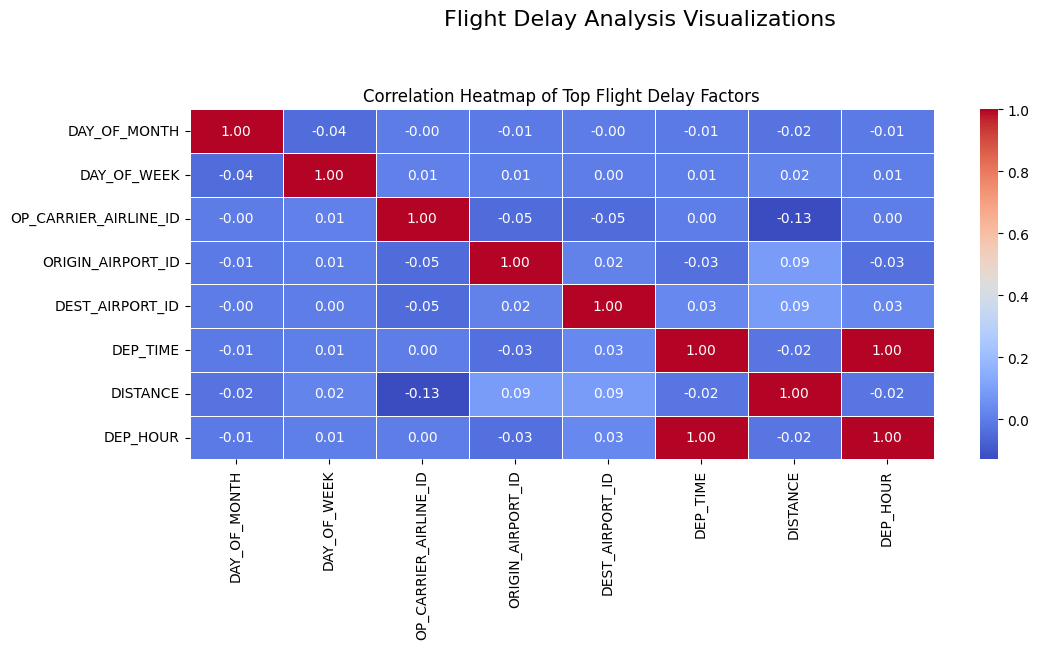

In [11]:
print("\n--- Exploratory Data Analysis ---")
print("Dataset Shape:", df.shape)

# Create more meaningful visualizations
plt.figure(figsize=(12, 10))
plt.suptitle('Flight Delay Analysis Visualizations', fontsize=16)

# Correlation heatmap for numerical columns only
numeric_df = df[feature_columns].select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Select top correlated features with target
if target_column in correlation_matrix.columns:
    target_correlations = correlation_matrix[target_column].abs().sort_values(ascending=False)
    print("\nTop numerical features correlated with delay:")
    print(target_correlations.head(10))
    top_features = target_correlations.index[:8]  # Top 8 features for visualization
else:
    top_features = numeric_df.columns[:8]  # First 8 features if target not in correlation matrix



# Plot correlation heatmap
plt.subplot(2, 1, 1)
sns.heatmap(correlation_matrix.loc[top_features, top_features], 
            annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap of Top Flight Delay Factors')


### Plotting delay distribution by day of week if available

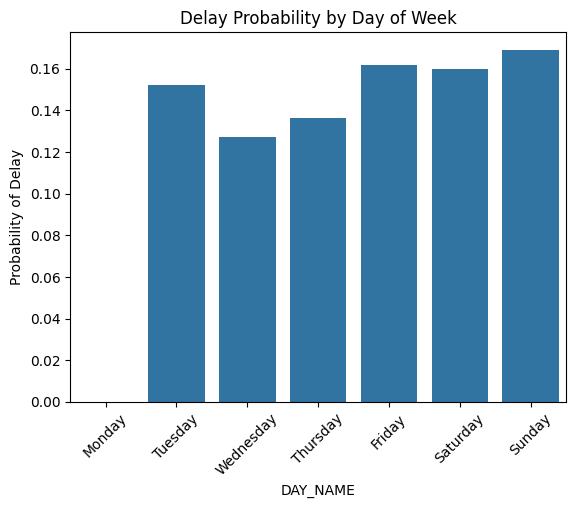

In [12]:

if 'DAY_OF_WEEK' in df.columns:
    plt.subplot(1, 1, 1)
    day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                   4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    df['DAY_NAME'] = df['DAY_OF_WEEK'].map(day_mapping)
    delay_by_day = df.groupby('DAY_NAME')[target_column].mean().reindex(
        [day_mapping[i] for i in range(7)])  # Ensure correct order
    sns.barplot(x=delay_by_day.index, y=delay_by_day.values)
    plt.title('Delay Probability by Day of Week')
    plt.xticks(rotation=45)
    plt.ylabel('Probability of Delay')


## Plotting delay distribution by carrier if OP_CARRIER exists

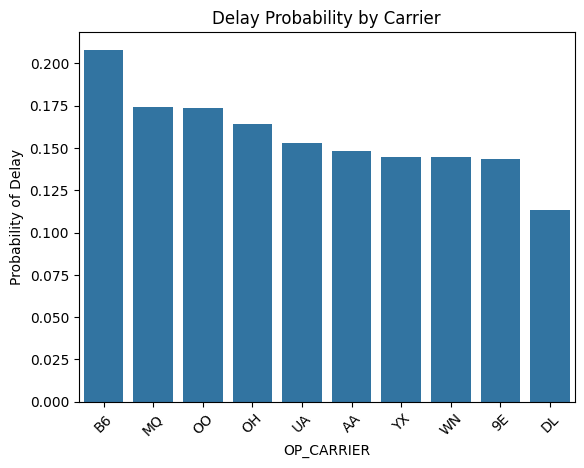

In [13]:

if 'OP_CARRIER' in df.columns:
    plt.subplot(1, 1, 1)
    # Get top carriers by frequency
    top_carriers = df['OP_CARRIER'].value_counts().nlargest(10).index
    carrier_delays = df[df['OP_CARRIER'].isin(top_carriers)].groupby('OP_CARRIER')[target_column].mean().sort_values(ascending=False)
    sns.barplot(x=carrier_delays.index, y=carrier_delays.values)
    plt.title('Delay Probability by Carrier')
    plt.xticks(rotation=45)
    plt.ylabel('Probability of Delay')

### Plot delay distribution by time of day if available

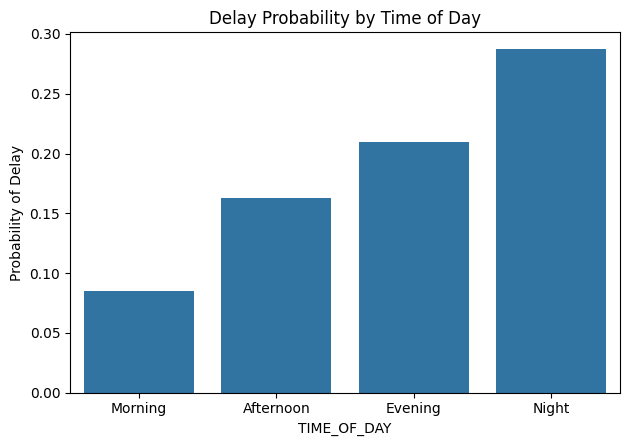

In [14]:
# Plot delay distribution by time of day if available
if 'TIME_OF_DAY' in df.columns:
    plt.subplot(1, 1, 1)
    time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    time_delays = df.groupby('TIME_OF_DAY')[target_column].mean()
    time_delays = time_delays.reindex(time_order)  # Ensure correct order
    sns.barplot(x=time_delays.index, y=time_delays.values)
    plt.title('Delay Probability by Time of Day')
    plt.ylabel('Probability of Delay')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
plt.show()



## Step 8: Distance vs Delay Visualization

/tmp/ipykernel_46917/968991396.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_by_distance = df.groupby('DISTANCE_BIN')[target_column].mean()


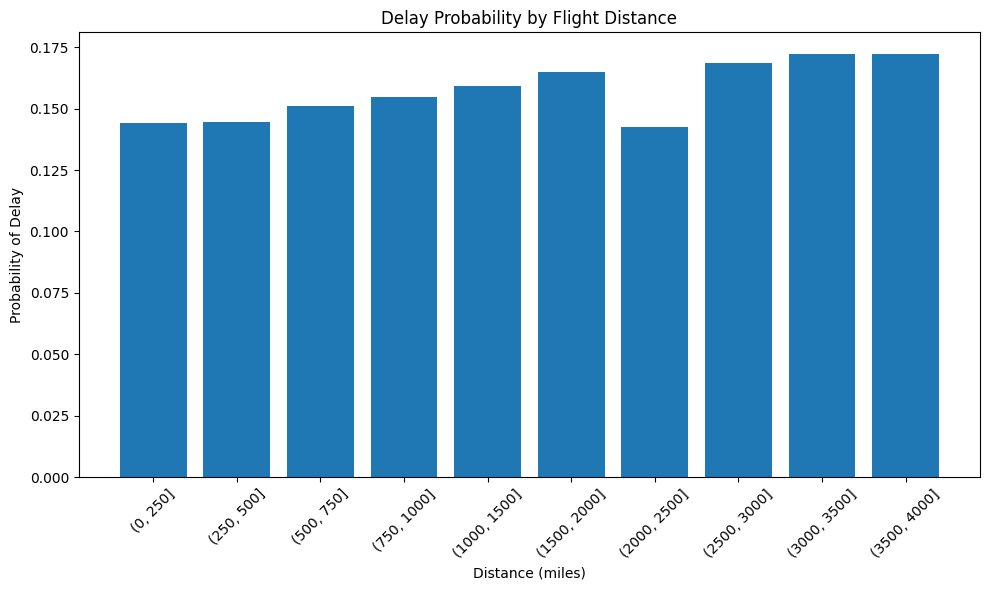

In [15]:
# Distance vs Delay visualization
if 'DISTANCE' in df.columns:
    plt.figure(figsize=(10, 6))
    # Create bins for distance
    distance_bins = [0, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    df['DISTANCE_BIN'] = pd.cut(df['DISTANCE'], bins=distance_bins)
    delay_by_distance = df.groupby('DISTANCE_BIN')[target_column].mean()
    
    # Plot relationship between distance and delay probability
    plt.bar(range(len(delay_by_distance)), delay_by_distance.values)
    plt.xticks(range(len(delay_by_distance)), [str(x) for x in delay_by_distance.index], rotation=45)
    plt.title('Delay Probability by Flight Distance')
    plt.xlabel('Distance (miles)')
    plt.ylabel('Probability of Delay')
    plt.tight_layout()
    plt.savefig('distance_vs_delay.png')
    plt.show()

## Step 9: Preparing Numerical and Categorical Features

In [16]:
# Prepare numerical and categorical features
numerical_features = df[feature_columns].select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df[feature_columns].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


Numerical features: ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'DISTANCE', 'DEP_HOUR', 'DISTANCE_PER_HOUR']
Categorical features: ['OP_UNIQUE_CARRIER', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK', 'TIME_OF_DAY', 'DISTANCE_GROUP']


## Step 10: Preparing Data for Modeling

In [17]:
# Define preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute NaN with median
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute NaN with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode
])

preprocessor = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features)
)


# Define X (features) and y (target)
X = df[feature_columns]
y = df[target_column]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in testing: {np.bincount(y_test)}")


Training set size: (190612, 16)
Testing set size: (47654, 16)
Class distribution in training: [161787  28825]
Class distribution in testing: [40448  7206]


## Step 11: Model Building

In [18]:
# Step 11: Model Building
# Linear Regression
linear_reg = LinearRegression()

# Decision Tree
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=30,
    min_samples_leaf=15,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# Create pipelines
linear_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_reg)
])

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', dt)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])

# Store models in a list
models = [linear_reg_pipeline, dt_pipeline, rf_pipeline]
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest']

## Step 12: Train Models with Timing

In [19]:
print("\n--- Model Training ---")
for i, (model, name) in enumerate(zip(models, model_names)):
    start_time = time.time()
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    training_time = time.time() -  start_time
    print(f"{name} trained in {training_time:.2f} seconds")


--- Model Training ---
Training Linear Regression...
Linear Regression trained in 34.38 seconds
Training Decision Tree...
Decision Tree trained in 27.68 seconds
Training Random Forest...
Random Forest trained in 57.70 seconds


## Step 13: Evaluating Models

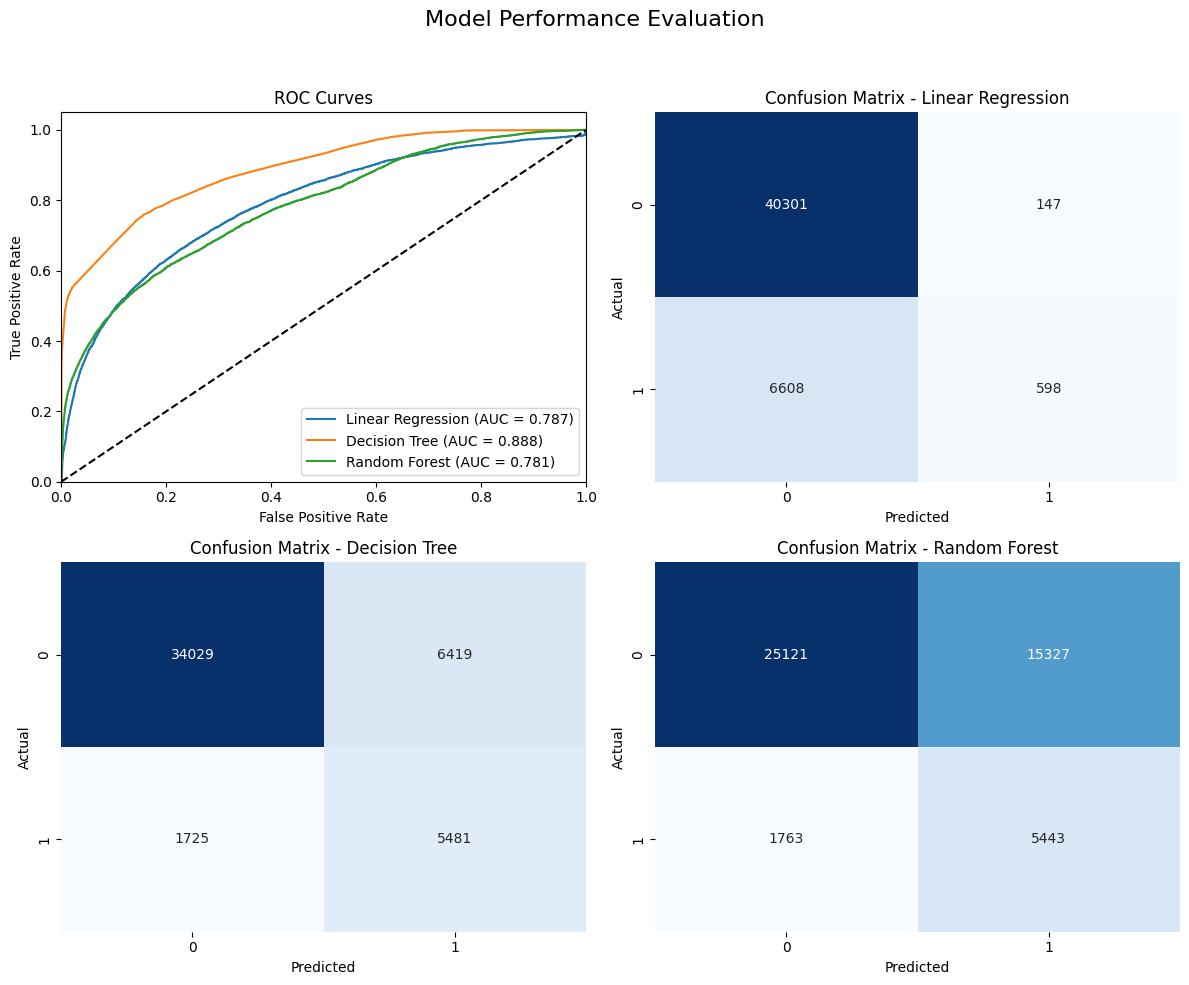

Model Performance Summary:


,Model,Accuracy,Precision,Recall,F1 Score,AUC,Log Loss,MSE,MAE,R2
0,Linear Regression,0.8582,0.8027,0.0830,0.1504,0.7869,0.4705,0.1146,0.2353,0.1070
1,Decision Tree,0.8291,0.4606,0.7606,0.5737,0.8876,0.3867,0.1709,0.1709,-0.3315
2,Random Forest,0.6414,0.2621,0.7553,0.3891,0.7808,0.6012,0.3586,0.3586,-1.7942


Best model: Decision Tree with F1 Score of 0.5737 and Accuracy of 0.8291


In [21]:
# Import required metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Define metrics dictionary
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': [],
    'Log Loss': [],
    'MSE': [],
    'MAE': [],
    'R2': []
}

plt.figure(figsize=(12, 10))
plt.suptitle('Model Performance Evaluation', fontsize=16)

for i, (model, name) in enumerate(zip(models, model_names)):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate regression metrics (MSE, MAE, R²) for all models
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    
    if name == 'Linear Regression':
        
        y_pred_class = (y_pred >= 0.5).astype(int)  # Threshold predictions at 0.5
    else:
        
        y_pred_class = y_pred
        y_pred_proba = model.predict_proba(X_test)[:, 1]  
    
    accuracy = accuracy_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class, zero_division=0)
    recall = recall_score(y_test, y_pred_class, zero_division=0)
    f1 = f1_score(y_test, y_pred_class, zero_division=0)
    
    if name == 'Linear Regression':
        # For Linear Regression, calculate AUC and Log Loss using binary predictions
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_score = auc(fpr, tpr)
        logloss = log_loss(y_test, y_pred)
    else:
        # For Decision Tree and Random Forest, calculate AUC and Log Loss using predicted probabilities
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)
        logloss = log_loss(y_test, y_pred_proba)
    
    # Store metrics
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)
    metrics['AUC'].append(auc_score)
    metrics['Log Loss'].append(logloss)
    metrics['MSE'].append(mse)
    metrics['MAE'].append(mae)
    metrics['R2'].append(r2)
    
    # Plot ROC curve (for all models)
    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
    
    # Plot confusion matrix (for all models)
    plt.subplot(2, 2, i+2)
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

# Finalize ROC curve plot
plt.subplot(2, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
plt.show()

# Create performance summary DataFrame
performance_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': metrics['Accuracy'],
    'Precision': metrics['Precision'],
    'Recall': metrics['Recall'],
    'F1 Score': metrics['F1 Score'],
    'AUC': metrics['AUC'],
    'Log Loss': metrics['Log Loss'],
    'MSE': metrics['MSE'],
    'MAE': metrics['MAE'],
    'R2': metrics['R2']
})

print("Model Performance Summary:")
display(performance_df.round(4))

# Find best model based on F1 score (balances precision and recall)
best_model_index = np.argmax(metrics['F1 Score'])
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

print(f"Best model: {best_model_name} with F1 Score of {metrics['F1 Score'][best_model_index]:.4f} and Accuracy of {metrics['Accuracy'][best_model_index]:.4f}")

## Step 14: Identify and Save the Best Model

In [24]:
# Find best model based on F1 score (balances precision and recall)
best_model_index = np.argmax(metrics['F1 Score'])
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

print(f"\nBest model: {best_model_name} with F1 Score of {metrics['F1 Score'][best_model_index]:.4f}")

# Save the best model
joblib.dump(best_model, 'best_flight_delay_model.pkl')
print("Best model saved as 'best_flight_delay_model.pkl'")


Best model: Decision Tree with F1 Score of 0.5737
Best model saved as 'best_flight_delay_model.pkl'


## Step 15: Feature Importance Analysis

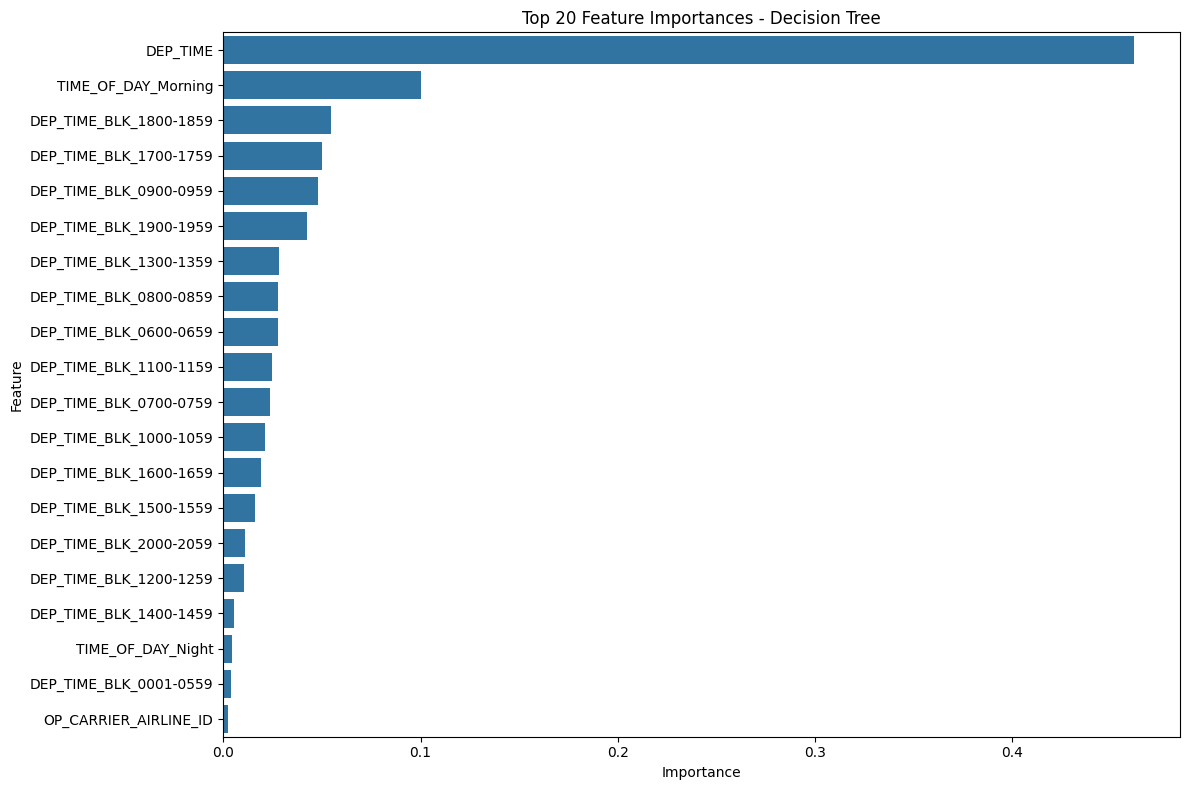


Top 10 most important features:
                    Feature  Importance
5                  DEP_TIME    0.461987
770     TIME_OF_DAY_Morning    0.100160
762  DEP_TIME_BLK_1800-1859    0.054849
761  DEP_TIME_BLK_1700-1759    0.050296
753  DEP_TIME_BLK_0900-0959    0.048256
763  DEP_TIME_BLK_1900-1959    0.042502
757  DEP_TIME_BLK_1300-1359    0.028333
752  DEP_TIME_BLK_0800-0859    0.027736
750  DEP_TIME_BLK_0600-0659    0.027716
755  DEP_TIME_BLK_1100-1159    0.024625


In [23]:
if best_model_name in ['Decision Tree', 'Random Forest']:
    # Get feature importances
    feature_imp = best_model.named_steps['model'].feature_importances_
    
    # Get feature names after preprocessing
    # For tree models, we need to get the feature names after one-hot encoding
    categorical_ohe = preprocessor.transformers_[1][1]
    if len(categorical_features) > 0:
        cat_feature_names = categorical_ohe.get_feature_names_out(categorical_features)
        all_feature_names = np.concatenate([numerical_features, cat_feature_names])
    else:
        all_feature_names = numerical_features
    
    # Create dataframe for feature importance
    feature_importance = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': feature_imp
    }).sort_values(by='Importance', ascending=False)
    
    # Plot top 20 feature importances
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(feature_importance))
    top_features = feature_importance.head(top_n)
    
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance_classification.png')
    plt.show()
    
    print(f"\nTop 10 most important features:")
    print(feature_importance.head(10))

In [27]:
print(df.columns)

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE', 'DEP_HOUR', 'TIME_OF_DAY', 'DISTANCE_GROUP',
       'DAY_NAME', 'DISTANCE_BIN'],
      dtype='object')


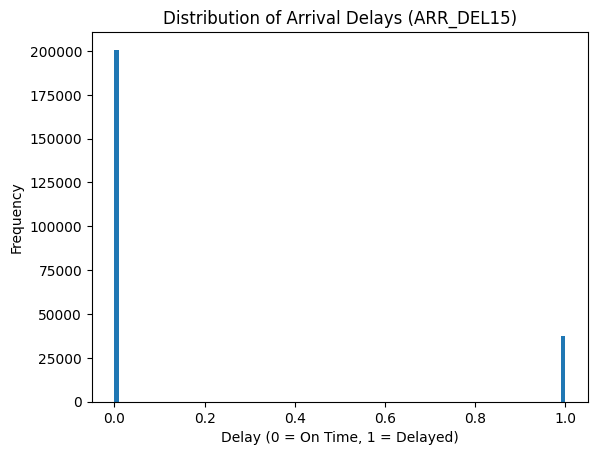

In [128]:
import matplotlib.pyplot as plt

plt.hist(df['ARR_DEL15'], bins=100)
plt.title('Distribution of Arrival Delays (ARR_DEL15)')
plt.xlabel('Delay (0 = On Time, 1 = Delayed)')
plt.ylabel('Frequency')
plt.show()

In [129]:
import pandas as pd

# Load the dataset
df = pd.concat([pd.read_csv('Jan_2019_ontime.csv'), pd.read_csv('Jan_2020_ontime.csv')], ignore_index=True)

# Filter for delayed flights
delayed_flights = df[df['DEP_DEL15'] == 1]

# Display the first few rows of delayed flights
print(delayed_flights.head())

    DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID  \
16             1            2                9E                  20363   
55             1            2                9E                  20363   
66             1            2                9E                  20363   
75             1            2                9E                  20363   
84             1            2                9E                  20363   

   OP_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
16         9E   N232PQ               3295              11433   
55         9E   N905XJ               3328              11193   
66         9E   N833AY               3338              13277   
75         9E   N905XJ               3344              13487   
84         9E   N833AY               3355              10397   

    ORIGIN_AIRPORT_SEQ_ID ORIGIN  ...  DEST  DEP_TIME DEP_DEL15  DEP_TIME_BLK  \
16                1143302    DTW  ...   EWR    1353.0       1.0     1200-1259   
55      